In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install yfinance 

Defaulting to user installation because normal site-packages is not writeable


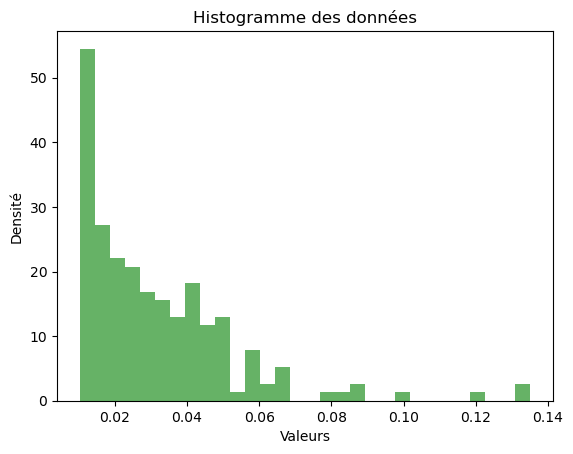

Statistique du test KS: 0.8931668207258102
p-value du test KS: 4.554820881540112e-180
Paramètres du modèle exponentiel (loc, scale): (0.010196087407130818, 0.021439016615433456)


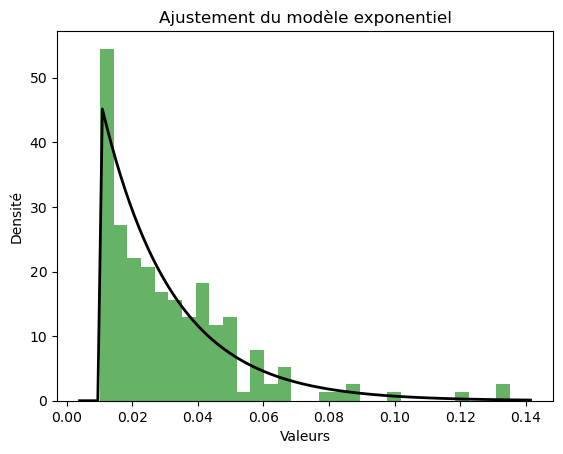

In [45]:
#on récupère les données sur une échelle de temps 
import yfinance as yf 
from scipy.stats import expon
from scipy.stats import kstest

#on prend comme expemple la société générale
sg = 'GLE.PA'

#on récupère les données via yahoo finance 
data = yf.Ticker(sg)

#o nrécupère les prix 
df = data.history(period='1d', start='2020-1-1', end='2020-12-31')

#affichage de la data frame 
df

Tt = []
ech =[]

for i in range(len(df['Close'])) : 
    if (np.abs(df['Close'][i]-df['Open'][i]))/df['Close'][i] > 0.01 : 
        ech.append((np.abs(df['Close'][i]-df['Open'][i]))/df['Close'][i])
        Tt.append(df.index[i])
 

count = [0] * len(Tt)
for i in range(len(Tt)) : 
    count[i] = count[i-1] + 1 

#on veut vérifier que ech soit bien un échantillon gaussien avant de passer à une simulation de hawkes

# Visualisation des données
plt.hist(ech, bins=30, density=True, alpha=0.6, color='g')
plt.title('Histogramme des données')
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.show()

# Test de Kolmogorov-Smirnov pour vérifier si les données suivent une loi exponentielle
statistic, pvalue = kstest(ech, 'expon')
print("Statistique du test KS:", statistic)
print("p-value du test KS:", pvalue)

# Ajustement du modèle exponentiel
params = expon.fit(ech)
print("Paramètres du modèle exponentiel (loc, scale):", params)

# Comparaison de la distribution ajustée avec les données empiriques
plt.hist(ech, bins=30, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, *params)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Ajustement du modèle exponentiel')
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.show()

On peut poursuivre la simulation par processus de hawkes, on a bien un échantillon qui suit une loi gaussienne. 
On va maintenant plot notre dataframe

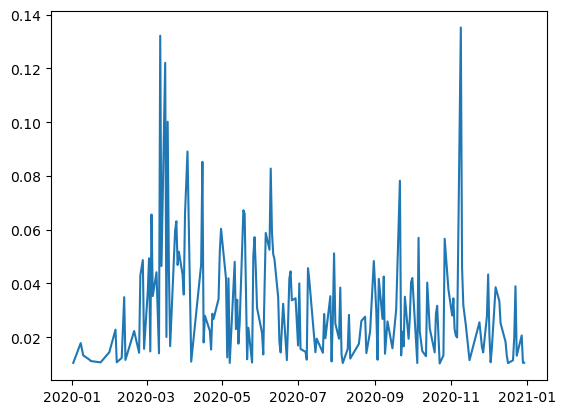

In [38]:
plt.plot(Tt,ech)

#RAJOUTER LES LEGENDES 

Text(0, 0.5, 'N(t)')

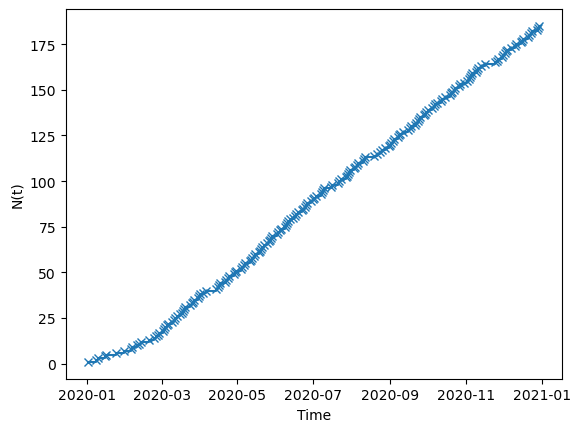

In [54]:
#représentation de la fonction de comptage
plt.plot(Tt, count, marker='x', drawstyle =  'steps-post')
plt.xlabel('Time')
plt.ylabel('N(t)')

#il faut estimer alpha beta mu (par la maxvraiesemblance) puis faire la simulation 

In [5]:
def intensity(s, T, alpha, beta, mu):
    intensity_value = mu
    for tau in T:
        intensity_value += alpha * np.exp(-beta * (s - tau))
    return intensity_value

In [6]:
#def intensity

In [7]:
def sim_Hawkes(mu, alpha, beta, T):
    t = []
    s = 0
    n = 0
    times = [0]
    events_count = [0]
    intensity_hawkes =[mu]
    DLaccept=[]
    DLrefus=[]
    timesrefus=[]

    while s < T:
        lambda_bar = intensity(s, t, alpha, beta, mu)
        u = np.random.uniform(0, 1)
        w = -np.log(u) / lambda_bar
        s += w
        D = np.random.uniform(0, 1)
        lambda_s = intensity(s, t, alpha, beta, mu)
        if D * lambda_bar <= lambda_s:
            DLaccept.append(D*lambda_bar)
            n += 1
            t.append(s)
            times.append(s)
            events_count.append(n)
            intensity_hawkes.append(lambda_s)
        else:
            DLrefus.append(D*lambda_bar)
            timesrefus.append(s)

    if t[-1] <= T:
        return times, events_count, intensity_hawkes,DLaccept,DLrefus,timesrefus
    else:
        return times[:-1], events_count[:-1], intensity_hawkes[:-1], DLaccept[:-1], DLrefus[:-1], timesrefus[:-1]

[1.2, 1.2, 1.488349352538585, 1.6168431013319013, 1.8582010209039934, 1.8244785549488163, 2.3206069490612027, 2.6880807395172654, 3.1905629015392867, 2.5086388454644077, 2.5354761919912456, 2.8874818466087726, 2.882206633001233, 3.4249778580167765, 3.814204341034006, 3.5244202951939645, 4.023059308306065]


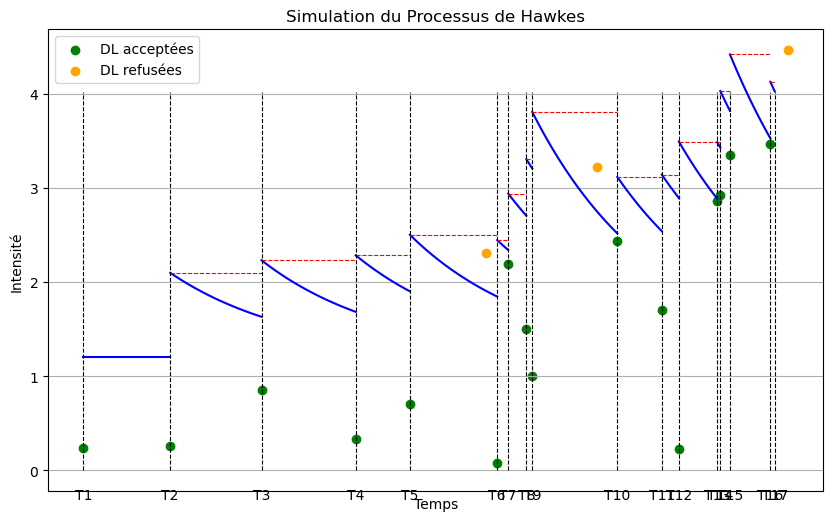

In [34]:
# paramètres
mu = 1.2
alpha = 0.6
beta = 0.8
T = 7

# Simulation du processus de Hawkes
times, events_count, intensity_hawkes, DLaccept, DLrefus, timesrefus = sim_Hawkes(mu, alpha, beta, T)


# Tracé de l'intensité conditionnelle λ(t)
plt.figure(figsize=(10, 6))
# Tracé de la fonction particulière entre les points
for i in range(len(times) - 1):
    x_values = np.linspace(times[i], times[i + 1], 100)  # 100 points entre deux temp
    if i==0 : 
        mu_vect = np.full(len(x_values),mu)
        plt.plot(x_values, mu_vect, color='blue', linestyle='-')
    else : 
        y_values = intensity(x_values, times[:i+1], alpha, beta, mu)
        plt.plot(x_values, y_values, color='blue', linestyle='-')
        plt.hlines(y=np.max(y_values), xmin=times[i], xmax = times[i+1] , color='red', linestyle='--', linewidth=0.8)

# pour tracer les droites verticales au moment des sauts
for i, t in enumerate(times):
    plt.vlines(x=t, ymin=0, ymax=np.max(intensity_hawkes), color='black', linestyle='--',linewidth=0.8)

# on nomme les sauts T1, T2 ...
for i, t in enumerate(times):
    plt.text(t, -0.3, f"T{i+1}", ha='center', color='black')

timesall=[]
for element in timesrefus:
    timesall.append(element)
for element in times:
    timesall.append(element)


times = times[:-1]
plt.scatter(times, DLaccept, color='green', label='DL acceptées')


# Tracé des valeurs de DLrefus aux temps timesrefus
plt.scatter(timesrefus, DLrefus, color='orange', label='DL refusées')

print(intensity_hawkes)
plt.xticks([])
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du Processus de Hawkes')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
len(timesrefus)

0